# RecSys-Bidirectional RNN with Embeddings

### Research problem:
The goal of the challenge is to develop a system for the task of automatic playlist continuation. Given a
set of playlist features, participants’ systems shall generate a list of recommended tracks that can be
added to that playlist, thereby ‘continuing’ the playlist.

#### Note: 
1. For generating embeddings please refer to Embeddings keras.ipynb
2. Extracting all playlists pertaining to particular keyword please use Workout playlist extraction.ipynb
3. Helpers function to generate batches helpers.py
4. Basic json used for sanity testing. mpd.slice.1000-1999_100_set.json
5. Embeddings are not uploaded due to github size restrictions


### Loading Libraries and Packages

In [3]:
# Dependencies
import numpy as np
import tensorflow as tf
import helpers
import sys
import json
import re
import collections
import os
import datetime
import glob
import math as m

# Importing LSTMs
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

/home/sachin/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
tf.__version__

'1.4.1'

### Defining MACROS and Environment Variables

In [45]:
# Add your trained path file here.

#fullpath = ['../train_set_untouched/data/mpd.slice.1000-1999.json']
#fullpath = ['sleep_100.json']
fullpath = ['sleep_1000.json']

### This is the pre-processing of the Spotify dataset

In [46]:
# Input to seq to seq model
X_train = []
# 0 and 1 are reserved for EOS and PAD
count = 2
play_list_names = []

# Dictionary to maintain the song index and track name, other features can be added later
track_dict = {}

# Dicionray to maintain count to uri mapping
uri_dict = {}
  
for item in fullpath:
    #print item
    f = open(item)
    file_content = f.read()
    f.close()
    mpd_slice = json.loads(file_content)


    # Playlist name list
    play_list_names += [re.sub('[^a-zA-Z0-9]+', '', mpd_slice['playlists'][idx]['name'].lower()) for idx in range(0, len(mpd_slice['playlists']))]
    #print play_list_names
    #print item, len(play_list_names), count

count += len(set(play_list_names))
#print count 
    
for item in fullpath:
    #print item
    f = open(item)
    file_content = f.read()
    f.close()
    mpd_slice = json.loads(file_content)


    # Looping to create the X_train
    for idx in range(0, len(mpd_slice['playlists'])):
        lst_current = [] 

        lst_current.append(play_list_names.index(re.sub('[^a-zA-Z0-9]+', '', mpd_slice['playlists'][idx]['name'].lower())) + 2)    

        for idy in range(0, len(mpd_slice['playlists'][idx]['tracks'])):
            track_uri = re.sub('spotify:track:', '', mpd_slice['playlists'][idx]['tracks'][idy]['track_uri'])
            if(track_uri not in track_dict):
                track_dict[track_uri] = count
                uri_dict[count] = [track_uri, mpd_slice['playlists'][idx]['tracks'][idy]['track_name']]
                count += 1
            lst_current.append(track_dict[track_uri])
            #print lst_current
            #print X_train, "sac"
        X_train.append(lst_current)
        #print "done", idx
    print "done"

    #print X_train
    

#print (X_train)
print (count)
print (len(play_list_names))
print (len(set(play_list_names)))

done
21374
893
1


### Printing some basic stats

In [47]:
X_train_orig = X_train
#print (X_train[0:10])

In [48]:
train_test_split = 0.8
X_train, X_test = X_train_orig[0:int(m.floor(train_test_split*len(X_train_orig)))],  X_train_orig[int(m.floor(train_test_split*len(X_train_orig))):len(X_train_orig)]
print "Train split is:", len(X_train), "and Test split is:", len(X_test)

Train split is: 714 and Test split is: 179


### Defining the PAD, EOS, Vocab size and other hyperparameters

In [11]:
PAD = 0
EOS = 1

vocab_size = count
input_embedding_size = 300

encoder_hidden_units = 300
decoder_hidden_units = encoder_hidden_units * 2

### Defining some placeholders for tensorflow variables

In [12]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

### Embeddings

In [16]:
# Modify this variable if you want to load the external embeddings
external_load_embeddings = True

In [18]:
# Module to load external embeddings.

if(external_load_embeddings == True):
    print "Loading the embeddings"
    embed_file = np.load('embedding_1000.npy')
    print embed_file.shape
    print vocab_size, input_embedding_size
    init = tf.constant(embed_file, dtype=tf.float32)
    embeddings = tf.get_variable('embeddings', trainable=False, initializer = init, dtype=tf.float32)
else:
    print "Training the embeddings"
    embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

Training the embeddings


### Lookup function to get embeddings as a continuous represemtation from one-hot inputs

In [21]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

## Encoder

We are using `tf.nn.bidirectional_dynamic_rnn` as the encoder for better understanding of the context

In [22]:
# Defining the encoder cell 
encoder_cell = LSTMCell(encoder_hidden_units)

In [23]:
# Defining the Bi-directional RNN with inputs and outputs merged

((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

### Forward and backward outputs and state are concatenated and used for attention

In [24]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

## Decoder

We are using raw_rnns for decoders as it allows to control what should output, what should be fed next, and hence allows us to include attention mechanism

In [25]:
# Defining the decoder cell 

decoder_cell = LSTMCell(decoder_hidden_units)

In [26]:
# Unstacting the inputs from batches 

encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

In this project the decoder will be able to predict sequences of lengths +2 additional steps. +500 did not work because of vanishing gradients

In [27]:
decoder_lengths = encoder_inputs_length + 2

## Label mapping for backpropagation

We are defining the weights and biases for the linear softmax layer to generate probability distribution for the predictions and map with the original sequence

In [28]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

Token preparation for EOS and PAD tokens to denote End of sequence and Padding for smaler sequences

In [29]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

Next we define two loop functions involving tensors to implement soft attention mechanism. Also by defining the loop functions we will be providing the previously generated decoder output to the current cell computation.


Loop transition function is a mapping `(time, previous_cell_output, previous_cell_state, previous_loop_state) -> (elements_finished, input, cell_state, output, loop_state)`. It is called *before* RNNCell to prepare its inputs and state. Everything is a Tensor except for initial call at time=0 when everything is `None` (except `time`).

In [30]:
# Loop initialization function. Loop initial state is function of only `encoder_final_state` and embeddings:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

Loop transition function

In [31]:
# Define transition function such that maximum probable previously generated token is passed as next input.
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths) 

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, input, state, output, loop_state)

Combining the initializer and transition functions to create a new raw_rnn.

In [32]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

Flattening the layers and getting the logits for the prediction

In [33]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

Getting the predictions in a tensor

In [34]:
decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

We are using softmax function for generating the prediction probabilities. Categorical crossentrpy is used as a loss function for computing the difference between the actual and predicted probability distributions

In [35]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer(learning_rate=0.004,).minimize(loss)

Initialize all the variables to check the basic model is correct or not

In [36]:
sess.run(tf.global_variables_initializer())

## Training on the dataset

In [37]:
batch_size = 10
epochs = 20

def next_feed(index):
    batch = X_train[index*batch_size: (index+1)*batch_size]
    #print ("Batch ", batch)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    #print "Encoder i/p:", encoder_inputs_
    decoder_targets_, _ = helpers.batch(
        [(sequence[1:len(sequence)]) + [EOS] + [PAD]*2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

Loss variable to track the loss after each epoch

In [38]:
loss_track = []

Running the train method and tracking the time for each epoch

In [39]:
sess.run(tf.initialize_all_variables())
import time


#try:
for i in range (epochs):
    tic = time.time()
    print ("Epoch", i)
    index = 0
    for index in range (len(X_train)/batch_size):
        fd = next_feed(index)
        #index = index
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        if(len(loss_track)%20 == 0):
            print loss_track[-1]
    print "Time taken per epoch: ", time.time() - tic

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 0)
10.595109
10.30477
10.296449
10.184431
Time taken per epoch:  68.8064701557
('Epoch', 1)
9.714048
9.86598
9.921107
9.7864485
Time taken per epoch:  67.9911730289
('Epoch', 2)
9.18689
9.516655
9.602545
9.488873
Time taken per epoch:  64.368366003
('Epoch', 3)
8.879628
9.154964
9.244562
9.11173
Time taken per epoch:  63.6041829586
('Epoch', 4)
8.625769
10.014691
9.189094
9.79594
Time taken per epoch:  63.6921460629
('Epoch', 5)
8.406231
8.554599
8.776959
8.89195
Time taken per epoch:  63.8741130829
('Epoch', 6)
7.8010907
8.121935
8.307964
8.090075
Time taken per epoch:  64.0411410332
('Epoch', 7)
7.44532
7.712841
8.060685
7.683864
Time taken per epoch:  64.5985150337
('Epoch', 8)
6.9585705
7.3844247
7.6310344
7.2426257
Time taken per epoch:  63.694589138
('Epoch', 9)
6.3532863
6.9843874
7.2370076
6.8569217
Time taken per epoch:  64.6257820129
('Epoch', 10)
5.925279
6.5897164
6.8851027
6.382462
Time tak

### Saving the model

In [41]:
import time
timestr = time.strftime("%m%d_%H%M")
print timestr
model_name =  './1000_playlist_50_epoch_400_neuron' + timestr + '.ckpt'

0426_2158


In [42]:
saver = tf.train.Saver(max_to_keep=1) 
#with tf.Session() as sess:
savePath = saver.save(sess, model_name)

In [ ]:
model_name_to_load = 'sleep_50_epoch_400_neuron0424_1424.ckpt'
saver = tf.train.import_meta_graph(model_name_to_load + '.meta')
saver.restore(sess, model_name_to_load)
# access a variable from the saved Graph, and s on:
#someVar = sess.run('varName:0')

## Testing on the toy dataset

In [61]:
# Trial test for 10 small batch
# Trial test for 100 batch
#X_test = [[2, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]]

# Trial test for 2 files
#X_test = [[2, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258]]
          
# Sleep test
X_test_orig = X_test

#print X_test_orig

## Running the predictions 

In [58]:
## Running the predictions
batch = X_test
batch_size = 1

def next_feed_test(index):
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch[index*batch_size: (index+1)*batch_size])
    decoder_targets_, _ = helpers.batch(
        [(sequence[1:len(sequence)]) + [EOS] + [PAD]*2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

def gen_batch_from_sample(x_input):
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(x_input)
    decoder_targets_, _ = helpers.batch(
        [(sequence[1:len(sequence)]) + [EOS] + [PAD]*2 for sequence in x_input]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

#fd = next_feed_test(0)

In [ ]:
predicted_sequence = []

for index in range (len(X_test)/batch_size):
    fd = next_feed_test(index)
    
    predict_ = sess.run(decoder_prediction, fd)
    
    for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
        print('  sample {}:'.format(index + 1))
        print('    input     > {}'.format(inp))
        print('    predicted > {}'.format(pred))
    predicted_sequence.append(predict_.T[0])

In [ ]:
print len(predicted_sequence[0])

## Methods to feed the predictions generated back as a input sequence and get more predictions

In [ ]:
from collections import OrderedDict

prediction_matrix = []
for index in range (len(X_test)/batch_size):
    fd = next_feed_test(index)
    #print fd
    
    predict_ = sess.run(decoder_prediction, fd)
    print "sachin debug", predict_
    
    # trying to generate 500 predictions
    
    orig_test_seq =  X_test[index] + predict_.reshape(len(predict_),).tolist()
    #print "sac", orig_test_seq, X_test[index][1:len(X_test[index])]
    play_list_seq = list(range(0, len(set(play_list_names))+1))
    test_seq = orig_test_seq

    
    count = 0
    while((len(set(test_seq)) != 500) and (len(set(orig_test_seq)) != 500)):
        # Removing the duplicates
        test_seq = list(OrderedDict.fromkeys(test_seq))
        # Removing the EOS and PAD
        test_seq = [x for x in test_seq if x not in [0,1]]
        
        fd_input = X_test[index] + [x for x in test_seq if x not in X_test[index]]
        
        fd_test = gen_batch_from_sample([fd_input])
        predict_ = sess.run(decoder_prediction, fd_test)
        local_prediction = predict_.reshape(len(predict_),).tolist()
        orig_test_seq +=  [x for x in local_prediction if x not in orig_test_seq]
        #print "iter", count, test_seq, orig_test_seq
        test_seq = orig_test_seq

        count += 1
        if(count == 100):
            break
    
    local_prediction = predict_.reshape(len(predict_),).tolist()
    orig_test_seq +=  [x for x in local_prediction if x not in orig_test_seq]
    
    
    seq_list = list(OrderedDict.fromkeys(orig_test_seq))
    
    seq_list = [x for x in seq_list if x not in play_list_seq]
    
    # Change
    seq_list = [x for x in seq_list if x not in X_test[index]]
    prediction_matrix.append(seq_list)
    

sachin debug [[  859]
 [ 9369]
 [33939]
 [13981]
 [16020]
 [16349]
 [ 5685]
 [12768]
 [  773]
 [  729]
 [  773]
 [  729]
 [  773]
 [  729]
 [  773]
 [  729]
 [  773]
 [  729]
 [  773]]
[2, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 859, 9369, 33939, 13981, 16020, 16349, 5685, 12768, 773, 729, 773, 729, 773, 729, 773, 729, 773, 729, 773]


In [38]:
for i in range(0, len(prediction_matrix)):
    song_names = [uri_dict[x][1] for x in prediction_matrix[i]]
    song_names = map(lambda x:x.encode("utf-8"), song_names)
    print "Predicted sequence:", i
    print ", ".join(song_names)
    print "\n"
    print prediction_matrix[i]

Predicted sequence: 0
Photograph, Love Is an Open Door, 7 Years, Wish You Were Here, I've Got a Dream - From "Tangled"/Soundtrack Version, You'll Be In My Heart, Does Ya Mama Know? (Dance Like That) #HEYNOW, Poor Unfortunate Souls - Broadway Cast Recording, Sorry, Where Are Ü Now (with Justin Bieber), Vroom Vroom, Applause, Come Together, Wildest Moments, Ghostbusters, When You're An Addams, Lucky, Dog Days Are Over, Dancing Through Life - From "Wicked" Original Broadway Cast Recording/2003, I've Never Felt So Good, Gold Angel - Savoir Adore Remix, C'Mon, Do I Wanna Know?, Friends on the Other Side - From "The Princess and the Frog" / Soundtrack Version, Breathe, Born For This, You Got Worked (feat. Mateo Senolia) [CASAMENA Stripped Remix] - Mixed, Ils appellent ça, Kif'n'dir, Positoovity - Broadway Cast Recording, Kiss the Girl - From "The Little Mermaid"/Soundtrack Version, Closer, Cheerleader, C.O.U.N.T.R.Y., It's My Life, Diss Me, Doin' it Right, Still Want You, Devil Eyes, The Wor

## Precision metrics computation (R-Precision and NDCG)

In [40]:
## R-Precision
def r_precision(r):
    """Score is precision after all relevant documents have been retrieved
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])

## DCG computation
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

## NDCG computation
def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg


## R-Precision and NDCG for a subset

In [42]:
# Computing the r-precision
test_idx = 0

## R-Precision
print "R-Precision is", len(X_train[test_idx]), len(list(set(prediction_matrix[0]) & set(X_train[test_idx])))/float(len(X_train[test_idx]))


## NDCG computation
ndcg_arr = [(len(X_train[test_idx]) - X_train[test_idx].index(x)) if x in X_train[test_idx] else 0 for x in prediction_matrix[0]]
print "NDCG metric:", ndcg_at_k(ndcg_arr, len(ndcg_arr))
print ndcg_arr + (500-len(ndcg_arr))*[0]
print "NDCG metric:", ndcg_at_k(ndcg_arr, len(ndcg_arr))

R-Precision is 190 0.0736842105263
NDCG metric: 0.21043817599412445
[0, 0, 0, 0, 0, 124, 0, 175, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 174, 163, 0, 0, 0, 0, 0, 0, 0, 0, 179, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 40, 0, 0, 0, 0, 142, 0, 161, 133, 0, 97, 0, 0, 0, 0, 0, 0, 0, 0, 172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Graphs of loss function vs epochs

loss 3.4077 after 1600 examples (batch_size=1)


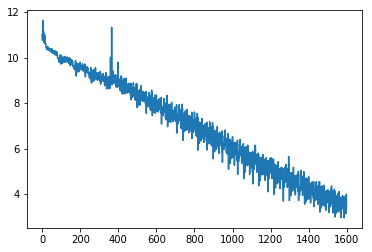

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))